## Movie Recommendation System Using CNNs (ResNet-50) and PyTorch

This project is focused on developing a movie recommendation system based on the visual features of movie posters. Instead of relying on textual metadata or user ratings, we extract features from movie posters using Convolutional Neural Networks (CNNs), specifically the ResNet-50 architecture, implemented in PyTorch.

## Objective
The objective is to recommend visually similar movies based on a given movie poster. By leveraging the ResNet-50 model, we extract feature embeddings from the poster images. These embeddings capture the semantic and visual characteristics of the movie posters, allowing the system to identify similar films based on visual cues.

## Approach
- Data Collection: A dataset of movie posters is gathered, where each poster corresponds to a specific movie.
- Feature Extraction with ResNet-50: We use the pre-trained ResNet-50 model to extract embeddings from the movie posters. ResNet-50, a deep convolutional neural network with 50 layers, is well-suited for this task due to its ability to learn high-level features from images.
The ResNet-50 model is pre-trained on ImageNet, and we use the output from one of the third layers from the bottom as the feature vector (embedding) for each poster.
- Embedding Generation: Each movie poster is passed through the ResNet-50 network, and we obtain a fixed-length feature vector representing the poster's content. These feature vectors (embeddings) are then stored for all the movies in the dataset.
- Similarity Calculation: To recommend similar movies, we calculate the cosine similarity (which was better than euclidean distance) between the embedding of the input movie poster and the embeddings of all other posters in the dataset.
- Movies with the highest similarity scores are then recommended as visually similar to the input movie.
- Recommendation System: When a user inputs a movie by selecting its poster, the system retrieves the top-k visually similar movie recommendations by comparing the embeddings.

## Tools and Libraries Used:
- PyTorch: For implementing and using the ResNet-50 model for feature extraction.
- ResNet-50: Pre-trained deep CNN used to extract meaningful features from the movie posters.
- Cosine Similarity: Used to compute the similarity between movie posters based on their embeddings.



This approach allows the recommendation system to suggest movies based on visual similarities, which could be particularly useful for users interested in a specific visual style or genre. By leveraging CNNs like ResNet-50, the system can capture complex patterns and features from the posters, leading to more accurate recommendations.

In [12]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import warnings
from tqdm.notebook import tqdm
from glob import glob
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Data preprocessing

In [3]:
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = glob(image_folder+"/*")
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_path


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomCrop(224), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_folder = './New/' # Here we use the folder containing the images used as database
dataset = ImageDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [5]:
device = torch.device("mps") ## "Cuda" if you use a GPU or "cpu" if you're on a cpu

## Models

### VGG16

In [89]:
model = models.vgg16(pretrained=True)
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-3])
model.eval()
model.to(device)

# 3. Extraire les caractéristiques
features_list = []
image_paths = []

with torch.no_grad():
    for images, paths in tqdm(dataloader):
        outputs = model(images.to(device))
        features_list.append(outputs.cpu().numpy())
        image_paths.extend(paths)


/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/4 [00:00<?, ?it/s]

### Resnet50 Features Extractor

In [31]:
class EncoderCNN(torch.nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-4]
        self.resnet = torch.nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    
        features = features.permute(0, 2, 3, 1)                           
        features = features.view(features.size(0), -1, features.size(-1))
        return features

In [32]:
encoder = EncoderCNN().to(device)

In [33]:
features_list = []
image_paths = []
encoder.eval()
with torch.no_grad():
    for images, paths in tqdm(dataloader):
        outputs = encoder(images.to(device))
        features_list.append(outputs.cpu().numpy())
        image_paths.extend(paths)

features = np.vstack(features_list)
a,b,c = features.shape
features = features.reshape(a,b*c)
features.shape

  0%|          | 0/18 [00:00<?, ?it/s]

(546, 401408)

## Images downloader

In [10]:
import requests
from io import BytesIO

In [11]:
def donwload(url,name,path):
    response = requests.get(url)
    if response.status_code==200:
        name = name.split("/")
        name = " ".join(name)
        name= path+name+".jpg"
        img = Image.open(BytesIO(response.content))
        img.save(name)

## Prediction

In [22]:
def display_images_in_two_rows(indices, image_dir):
    num_images = len(indices)
    num_rows = 2
    num_cols = 5
    plt.figure(figsize=(15, num_cols))
    
    for i, idx in enumerate(indices):
        img_path = image_dir[idx]
        img = Image.open(img_path).convert('RGB')
        
        plt.subplot(num_rows, num_cols, i + 1)  # Placer les images en deux lignes
        plt.imshow(img)
        plt.axis('off')
        title = image_paths[idx].split("/")[-1][:-4]
        plt.title(f'{title}')
        
    
    plt.tight_layout()
    plt.show()

# Afficher les 5 images les plus proches en deux lignes
# 

In [28]:
def prediction_and_display(test_url,K=10):

    donwload(test_url,"test","./testImages/")
    test_dataset = ImageDataset("./testImages/", transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    features_list = []

    with torch.no_grad():
        for images, _ in tqdm(test_dataloader):
            outputs = encoder(images.to(device))
            features_list.append(outputs.cpu().numpy())
    
    test_features = np.vstack(features_list)
    test_features = test_features.reshape(test_features.shape[0],test_features.shape[1]*test_features.shape[2])
    cos_distances = cosine_distances(test_features, features).flatten()
    closest_indices = np.argsort(cos_distances)
    
    if sorted(cos_distances)[0]<0.1:
        closest_indices = closest_indices[1:K+1]
    else:
        closest_indices = closest_indices[:K]
        
    testImage = Image.open("./testImages/test.jpg")
    image_dir = glob('./New/*')

    plt.figure(figsize=(6,4))
    plt.imshow(testImage)
    plt.axis('off')
    plt.title("Test Image")
    
    print(f"{K} Similar posters ".center(80,"-"))
    display_images_in_two_rows(closest_indices, image_dir)


#### You have to provide the link of the image you want

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------------10 Similar posters -------------------------------


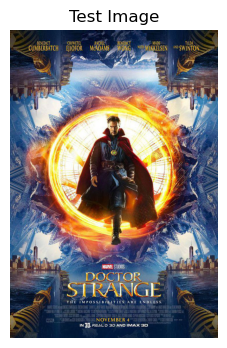

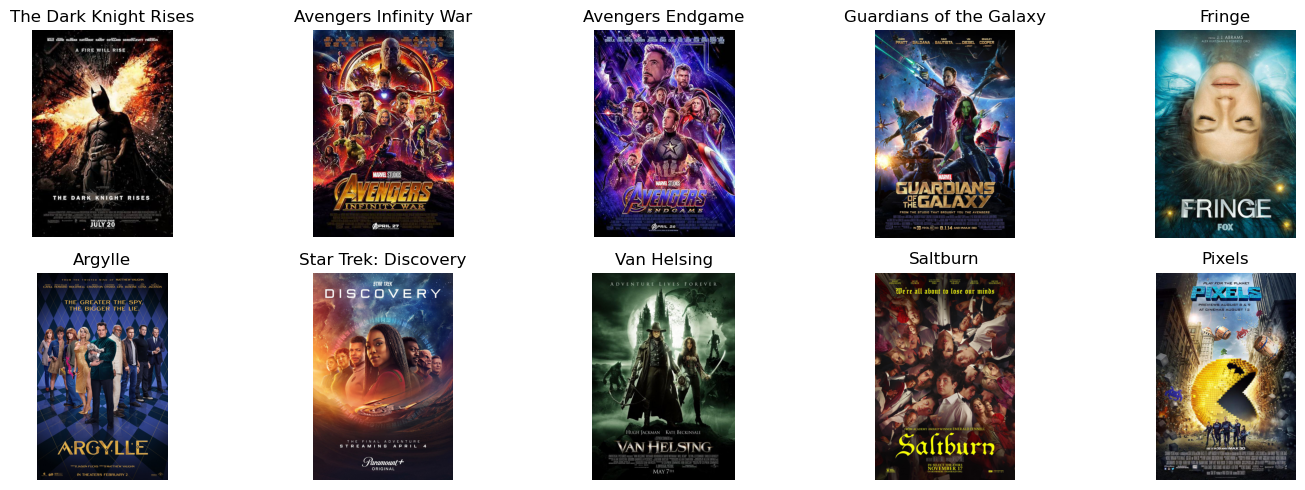

In [39]:
prediction_and_display(test_url="https://www.francetvinfo.fr/pictures/fMRivsCPbK850-I46F6y7qXcGRI/fit-in/720x/2019/04/12/strange_c.jpg")